In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch

%load_ext autoreload
%autoreload 2

# constants
THETA_LABELS = ['ss', 'tau', 'mu1', 'mu2', 'gam1', 'gam2']

# STATS 370
## Final project

In [2]:
from plot_utils import plot_dist, plot_marginals, plot_acorr, set_plt_settings
from dist_utils import prob_post, value_mh_cand, prob_mh_cand
from dist_utils import val_gibbs_ss, val_gibbs_tau, val_gibbs_mu, val_gibbs_gam
from dist_utils import prob_HMC
from mc_utils import MH, leapfrog, HMC

set_plt_settings()

In [3]:
# read in data
data = np.genfromtxt('data.csv', delimiter=',', skip_header=1, usecols=(1,2,3))
groups = torch.tensor(data[:,0].astype(int))
Y = torch.tensor(data[:, 1:], requires_grad=True)

# Metropolis Hasting
### Grid search for best hyperparameters

In [7]:
# grid search
# vary variances of proposal distributions to i) increase acceptance probability and ii) decrease acorr
x0 = torch.tensor([0.25, 0.5, -1, -1, 0, 0])
T = 1000
burn_in = 100
acorr_threshold = 0.3
steps_threshold = 50
report_mh = {}
best_accept_mh = 0.0

vmgs = [0.0001, 0.001, 0.01, 0.1]
vts = [0.0001, 0.001, 0.01, 0.1]
vsss = [0.0001, 0.001, 0.01, 0.1]
best_params_mh = (vmgs[0], vts[0], vsss[0])

# search hyperparameter space
for vmg in tqdm(vmgs):
    for vt in vts:
        for vss in vsss:
            # run MH
            xt, cands, status = MH(x=x0, Y=Y, groups=groups, var_mg=vmg, var_t=vt, var_ss=vss, T=T, verbose=False)
            # get and log stats
            pct_accept = np.sum(status[burn_in:] == 'a') / len(status)
            lags = np.apply_along_axis(sm.tsa.acf, axis=0, arr=xt, nlags=T/2)
            steps = np.argmin(np.abs(lags - acorr_threshold), axis=0).tolist()
            report_mh[vss, vt, vmg] = [pct_accept] + steps
            
            # remember best (defined as better accuracy while preserving lag)
            if (pct_accept > best_accept_mh) & (np.max(steps) < steps_threshold):
                best_accept_mh = pct_accept
                best_params_mh = (vmg, vt, vss)

print('best parameters (var mu/gam, var tau, var ss):', best_params_mh)

100%|█████████████████████████████████████████████| 4/4 [02:02<00:00, 30.51s/it]

best parameters (var mu/gam, var tau, var ss): (0.01, 0.01, 0.01)


### Run with selected hyperparameters for the proposal distribution

In [8]:
# optimal parameters
x0 = torch.tensor([0.25, 0.5, -1, -1, 0, 0])
T = 1000
vmg, vt, vss = best_params_mh

In [25]:
# toy parameters
x0 = torch.tensor([0.25, 0.5, -1, -1, 0, 0])
vmg, vt, vss = (0.01, 0.01, 0.01)
T = 10000

In [26]:
xt_mh, cands_mh, status_mh = MH(x=x0, Y=Y, groups=groups, var_mg=vmg, var_t=vt, var_ss=vss, T=T)

100%|████████████████████████████████████| 10000/10000 [00:18<00:00, 541.25it/s]


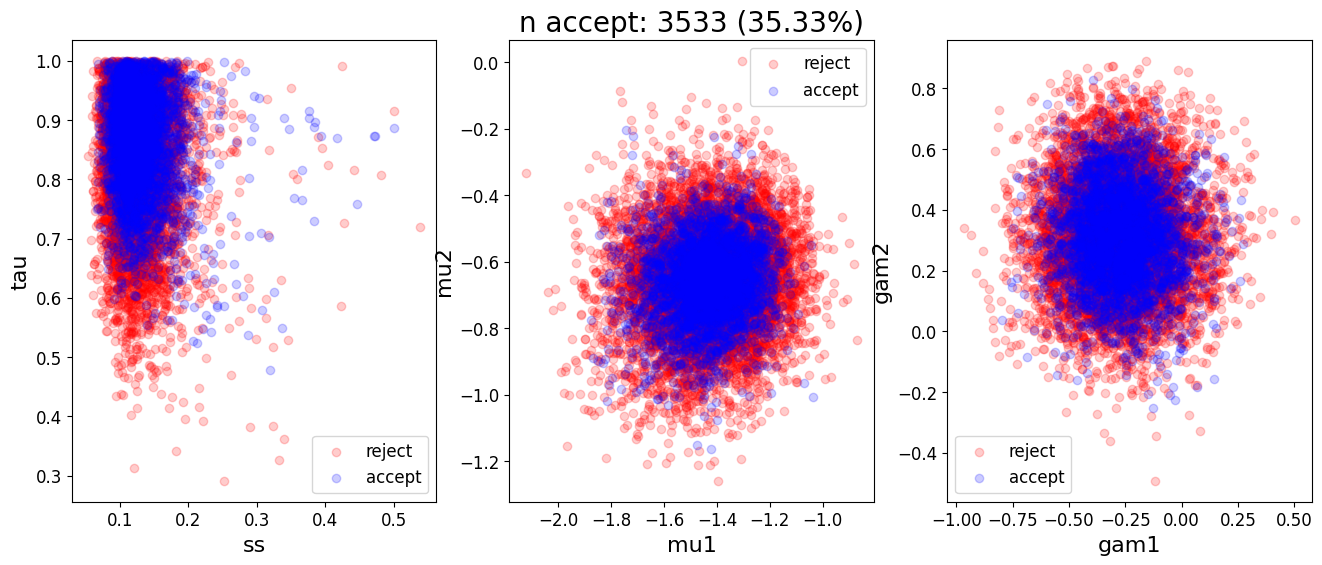

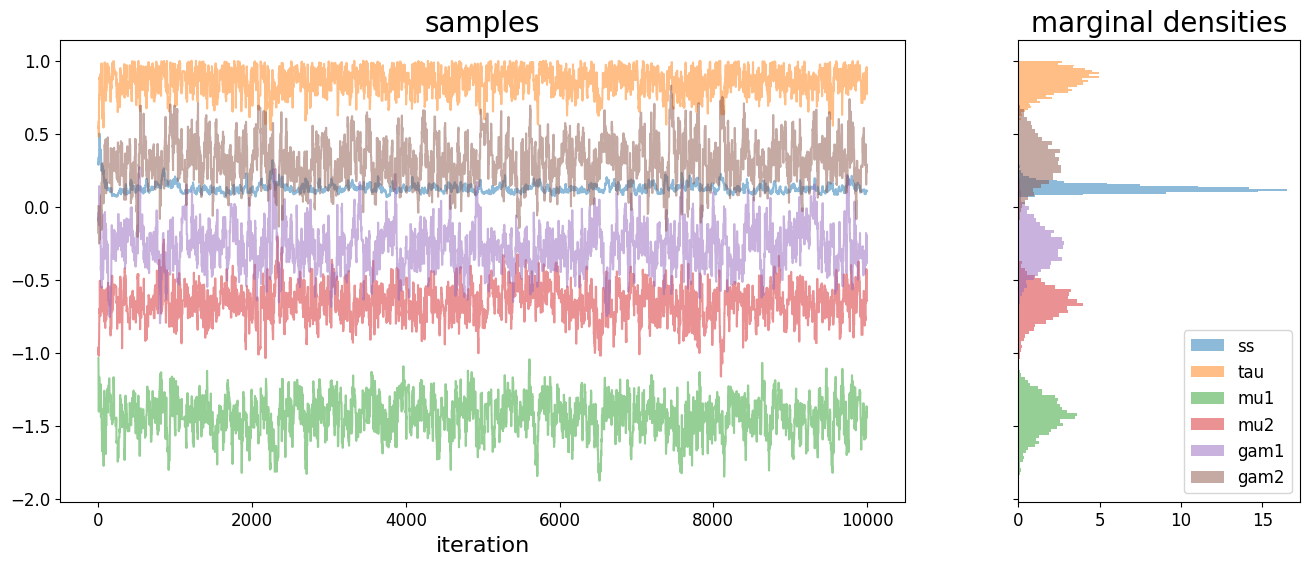

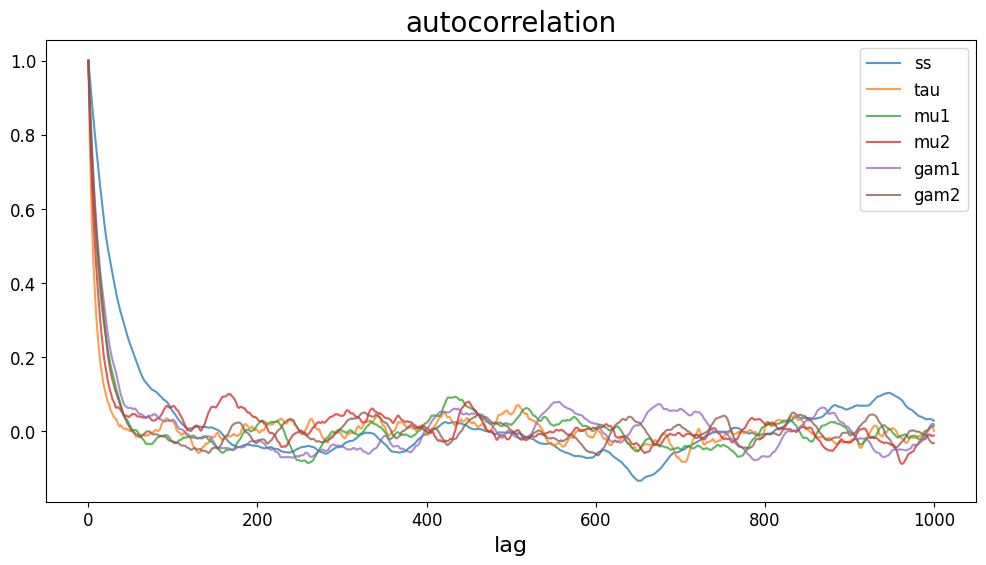

In [27]:
plot_dist(cands_mh, plot_status=True, status=status_mh)
plot_marginals(xt_mh)
plot_acorr(xt_mh, nlags=T/10)

In [28]:
# read-out statistics
stats_mh = {}
stats_mh['mean'] = np.mean(xt_mh, axis=0)
stats_mh['var'] = np.var(xt_mh, axis=0)
stats_mh['median'] = np.median(xt_mh, axis=0)
for pctl in [0, 10, 25, 50, 75, 90, 100]:
    stats_mh[f'p{pctl}'] = np.percentile(xt_mh, pctl, axis=0)
stats_mh = pd.DataFrame(stats_mh).T
stats_mh.columns = THETA_LABELS
print('univariate statistics')
display(stats_mh)

# covariance
cov_mh = pd.DataFrame(np.cov(xt_mh.T))
cov_mh.columns = THETA_LABELS
cov_mh.index = THETA_LABELS
print('covariance')
display(cov_mh)

univariate statistics


,ss,tau,mu1,mu2,gam1,gam2
mean,0.126411,0.861130,-1.433596,-0.661197,-0.274591,0.315382
var,0.001088,0.007115,0.016563,0.013535,0.022860,0.022883
median,0.121054,0.871078,-1.428801,-0.658542,-0.278566,0.311405
p0,0.066116,0.479033,-1.878005,-1.163383,-0.798702,-0.252355
p10,0.093818,0.746501,-1.608151,-0.805370,-0.459432,0.127956
p25,0.105873,0.805659,-1.514628,-0.733183,-0.373609,0.210716
p50,0.121054,0.871078,-1.428801,-0.658542,-0.278566,0.311405
p75,0.140455,0.927690,-1.340643,-0.583167,-0.179163,0.418944
p90,0.162738,0.964751,-1.269483,-0.518814,-0.080952,0.516879
p100,0.500839,0.999932,-1.038245,-0.204600,0.271510,0.828326


covariance


,ss,tau,mu1,mu2,gam1,gam2
ss,0.001088,-0.000324,0.000018,-0.000137,-0.000050,-0.000329
tau,-0.000324,0.007116,0.005562,0.003172,-0.001355,0.000332
mu1,0.000018,0.005562,0.016564,0.002371,-0.006128,0.000245
mu2,-0.000137,0.003172,0.002371,0.013537,-0.000695,-0.005367
gam1,-0.000050,-0.001355,-0.006128,-0.000695,0.022862,-0.000740
gam2,-0.000329,0.000332,0.000245,-0.005367,-0.000740,0.022886


# Gibs sampling

In [22]:
T = 10000
xt_g = []
continuous_scan = True
cond_dists = [val_gibbs_ss, val_gibbs_tau, val_gibbs_mu, val_gibbs_gam]

# Initialize then iterate
x0 = np.array((0.1, 0.75, np.array([0,0]), np.array([0,0])), dtype=object)
x = x0

for t in tqdm(range(T)):
    # sample iteratively from conditional distributions
    # determine scan
    if continuous_scan:
        update_idx = np.array(range(4))
    else:
        update_idx = np.random.choice(range(4), 4, replace=False)
    
    for j in update_idx:
        x[j] = cond_dists[j](x, Y.detach().numpy(), groups)
    
    # record in flattened state
    xt_g += [np.hstack(x)]

xt_g = np.array(xt_g)

100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1109.25it/s]


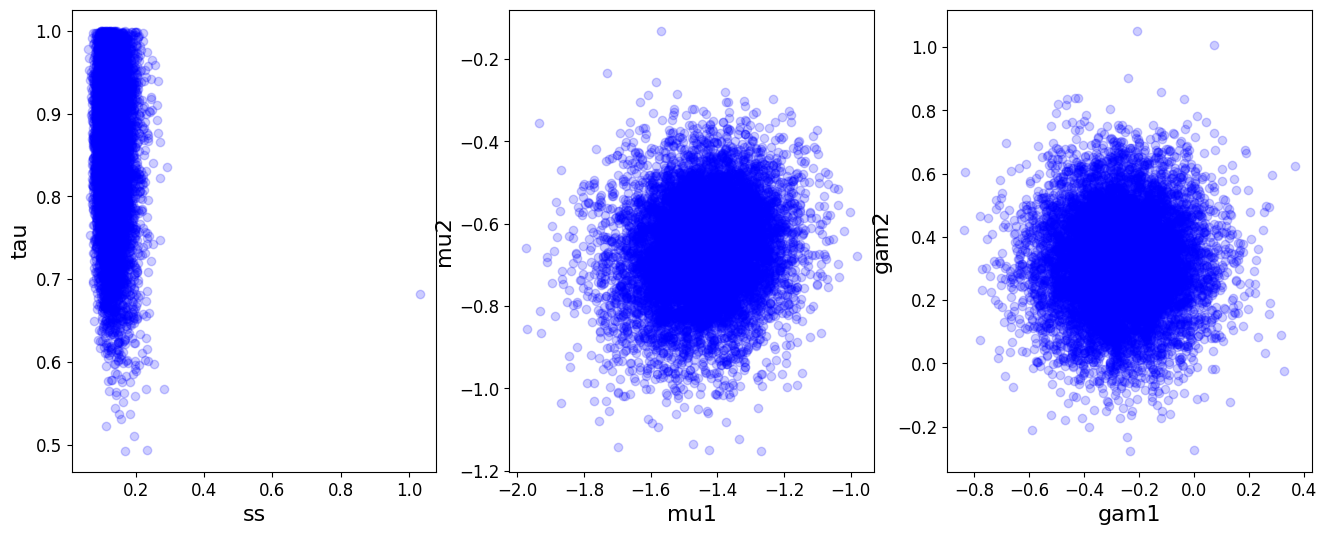

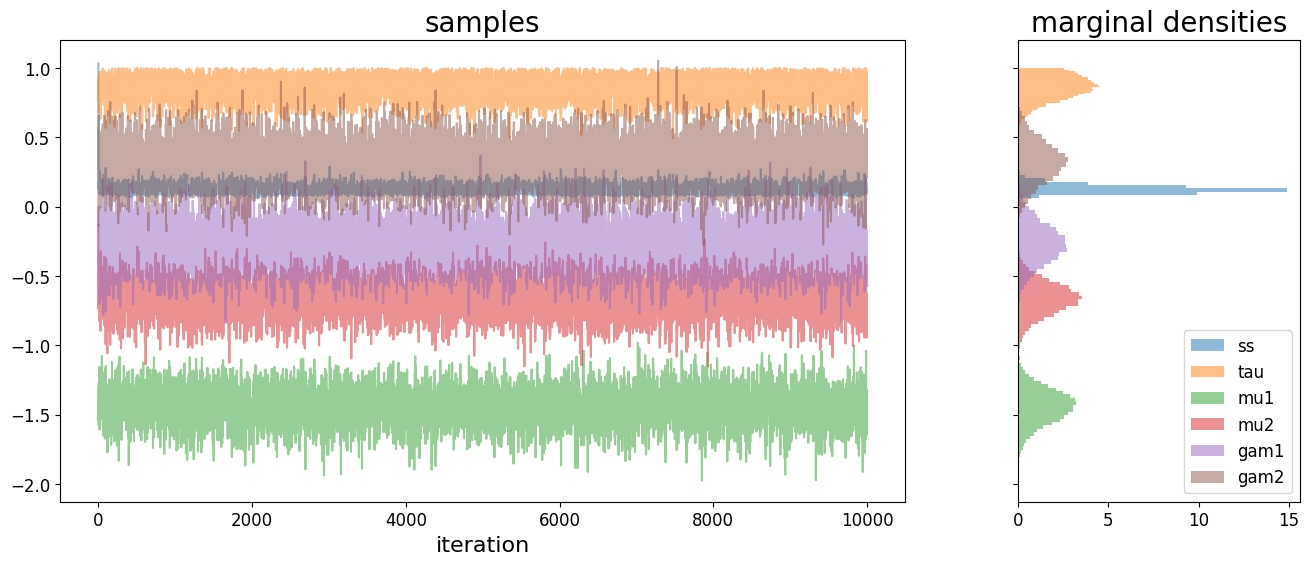

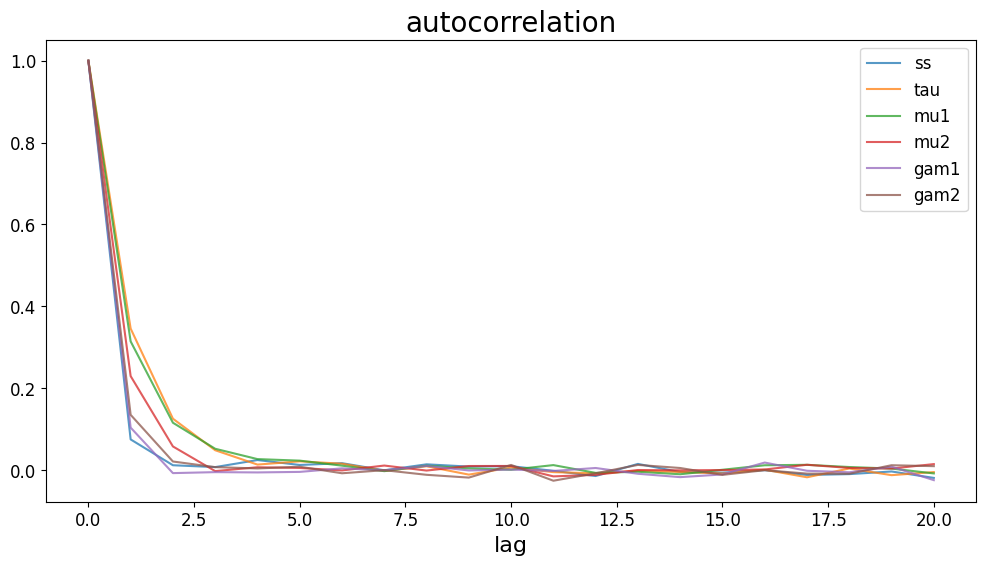

In [23]:
plot_dist(xt_g, plot_status=False)
plot_marginals(xt_g)
plot_acorr(xt_g, nlags=20)

In [24]:
# read-out statistics
stats_g = {}
stats_g['mean'] = np.mean(xt_g, axis=0)
stats_g['var'] = np.var(xt_g, axis=0)
stats_g['median'] = np.median(xt_g, axis=0)
for pctl in [0, 10, 25, 50, 75, 90, 100]:
    stats_g[f'p{pctl}'] = np.percentile(xt_g, pctl, axis=0)
stats_g = pd.DataFrame(stats_g).T
stats_g.columns = THETA_LABELS
print('univariate statistics')
display(stats_g)

# covariance
cov_g = pd.DataFrame(np.cov(xt_g.T))
cov_g.columns = THETA_LABELS
cov_g.index = THETA_LABELS
print('covariance')
display(cov_g)

univariate statistics


,ss,tau,mu1,mu2,gam1,gam2
mean,0.127144,0.855179,-1.439045,-0.662492,-0.267809,0.320601
var,0.000896,0.007375,0.016052,0.014112,0.023130,0.023553
median,0.123255,0.863256,-1.434233,-0.659744,-0.268843,0.322475
p0,0.059477,0.492930,-1.974481,-1.151771,-0.838456,-0.276137
p10,0.094132,0.737660,-1.601021,-0.814833,-0.460194,0.121428
p25,0.106911,0.798622,-1.521110,-0.737670,-0.368712,0.219409
p50,0.123255,0.863256,-1.434233,-0.659744,-0.268843,0.322475
p75,0.143117,0.922195,-1.353108,-0.581386,-0.167783,0.421313
p90,0.164907,0.964260,-1.282583,-0.514338,-0.072802,0.513927
p100,1.032135,0.999965,-0.979522,-0.130978,0.367971,1.051966


covariance


,ss,tau,mu1,mu2,gam1,gam2
ss,0.000896,-0.000257,-0.000186,-0.000126,-0.000015,-0.000070
tau,-0.000257,0.007376,0.005095,0.003394,-0.000540,0.000755
mu1,-0.000186,0.005095,0.016054,0.002188,-0.006290,0.000565
mu2,-0.000126,0.003394,0.002188,0.014113,0.000166,-0.005992
gam1,-0.000015,-0.000540,-0.006290,0.000166,0.023132,0.000085
gam2,-0.000070,0.000755,0.000565,-0.005992,0.000085,0.023556


# Hamiltonian Monte Carlo

### Grid search

In [41]:
# vary variances of proposal distributions to i) increase acceptance probability and ii) decrease acorr
q0 = torch.tensor([0.25, 0.5, -1, -1, 0, 0])
scale = 1000 # used to implement boundary constraint on sigma and tau
T = 300 # iterations for grid search
burn_in = 0
acorr_threshold = 0.5
steps_threshold = 75
report_hmc = {}
best_accept_hmc = 0.0

# hyperparameter grid
M_rats = [
#     [1, 1, 1, 1, 1, 1],
#       [0.5, 1, 1, 1, 1, 1],
      [0.25, 0.5, 1, 1, 1, 1],
#       [0.25, 0.5, 1, 1, 0.75, 0.75]
]
M_scales = [1, 1.5, 2]
Ls = [5, 10, 20]
epss = [0.01, 0.001, 0.0001]
best_params_hmc = (M_rats[0], M_scales[0], Ls[0], epss[0])

# search hyperparameter space
for i, M_rat in enumerate(tqdm(M_rats, disable=True)):
    for M_scale in M_scales:
        M = M_scale*torch.diag(torch.tensor(M_rat, dtype=torch.float))
        M_inv = torch.linalg.inv(M)
        p0 = torch.tensor(sps.multivariate_normal.rvs(mean=np.repeat(0,len(q0)), cov=M)).float()
        for L in Ls:
            for eps in epss:
                print('running:', M_rat, M_scale, L, eps)
                # run MH
                qt, cands, status = HMC(q=q0, p=p0, Y=Y, groups=groups, M=M, M_inv=M_inv, 
                                        eps=eps, L=L, T=T, verbose=False)
                # get and log stats
                pct_accept = np.sum(status[burn_in:] == 'a') / len(status)
                lags = np.apply_along_axis(sm.tsa.acf, axis=0, arr=qt, nlags=T/10)
                steps = np.argmin(np.abs(lags - acorr_threshold), axis=0).tolist()
                report_hmc[i, M_scale, L, eps] = [pct_accept] + steps
                
                # remember best
                if (pct_accept > best_accept_hmc):
                    best_accept_hmc = pct_accept
                    best_params_hmc = (M_rat, M_scale, L, eps)

print('best parameters (Mrat, Mscale, L, eps):', best_params_hmc)

running: [0.25, 0.5, 1, 1, 1, 1] 1 5 0.01
running: [0.25, 0.5, 1, 1, 1, 1] 1 5 0.001
running: [0.25, 0.5, 1, 1, 1, 1] 1 5 0.0001
running: [0.25, 0.5, 1, 1, 1, 1] 1 10 0.01
running: [0.25, 0.5, 1, 1, 1, 1] 1 10 0.001
running: [0.25, 0.5, 1, 1, 1, 1] 1 10 0.0001
running: [0.25, 0.5, 1, 1, 1, 1] 1 20 0.01
running: [0.25, 0.5, 1, 1, 1, 1] 1 20 0.001
running: [0.25, 0.5, 1, 1, 1, 1] 1 20 0.0001
running: [0.25, 0.5, 1, 1, 1, 1] 1.5 5 0.01
running: [0.25, 0.5, 1, 1, 1, 1] 1.5 5 0.001
running: [0.25, 0.5, 1, 1, 1, 1] 1.5 5 0.0001
running: [0.25, 0.5, 1, 1, 1, 1] 1.5 10 0.01
running: [0.25, 0.5, 1, 1, 1, 1] 1.5 10 0.001
running: [0.25, 0.5, 1, 1, 1, 1] 1.5 10 0.0001
running: [0.25, 0.5, 1, 1, 1, 1] 1.5 20 0.01
running: [0.25, 0.5, 1, 1, 1, 1] 1.5 20 0.001
running: [0.25, 0.5, 1, 1, 1, 1] 1.5 20 0.0001
running: [0.25, 0.5, 1, 1, 1, 1] 2 5 0.01
running: [0.25, 0.5, 1, 1, 1, 1] 2 5 0.001
running: [0.25, 0.5, 1, 1, 1, 1] 2 5 0.0001
running: [0.25, 0.5, 1, 1, 1, 1] 2 10 0.01
running: [0.25, 0.5, 1, 

### Run with best hyperparams

In [42]:
# best parameters
T=10000
M_rat, M_scale, L, eps = best_params_hmc
M = M_scale*torch.diag(torch.tensor(M_rat, dtype=torch.float))
M_inv = torch.linalg.inv(M)

In [50]:
# toy parameters
T=10000
M_rat, M_scale, L, eps = ([0.25, 0.5, 1, 1, 1, 1], 1.5, 30, 0.005)
M = M_scale*torch.diag(torch.tensor(M_rat, dtype=torch.float))
M_inv = torch.linalg.inv(M)

In [51]:
q0 = torch.tensor([0.25, 0.5, -1, -1, 0, 0], dtype=torch.float)
p0 = torch.tensor(sps.multivariate_normal.rvs(mean=np.repeat(0,len(q0)), cov=M)).float()
q_hmc, cands_hmc, status_hmc = HMC(q0, p0, Y, groups, M, M_inv, eps, L, T)

100%|█████████████████████████████████████| 10000/10000 [07:41<00:00, 21.68it/s]


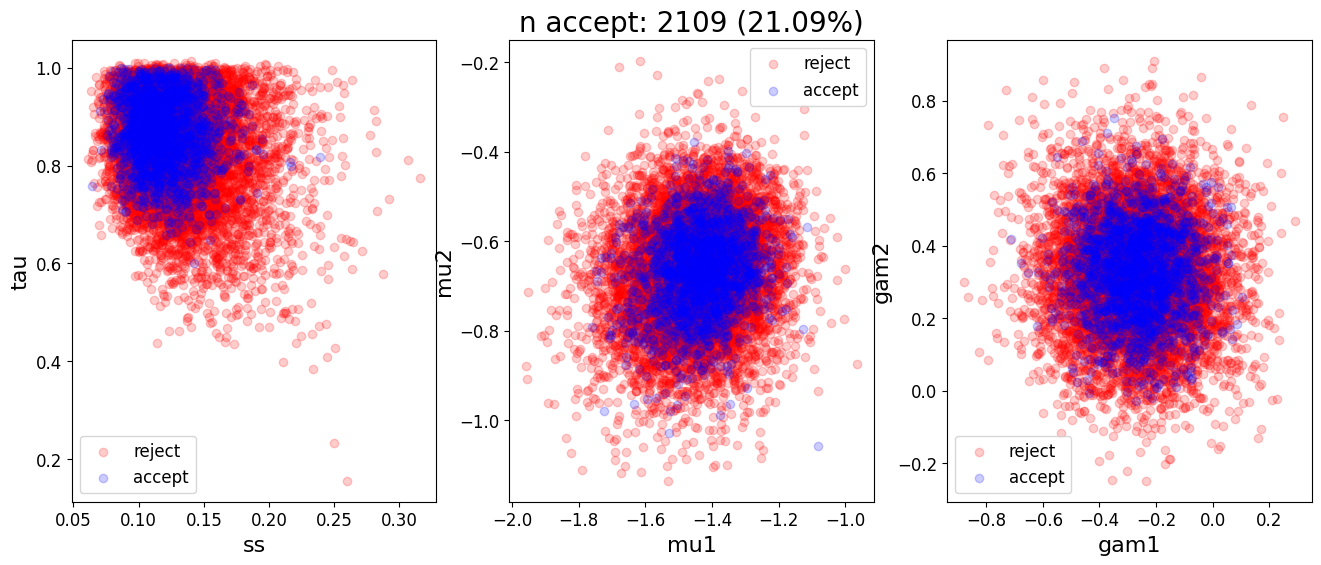

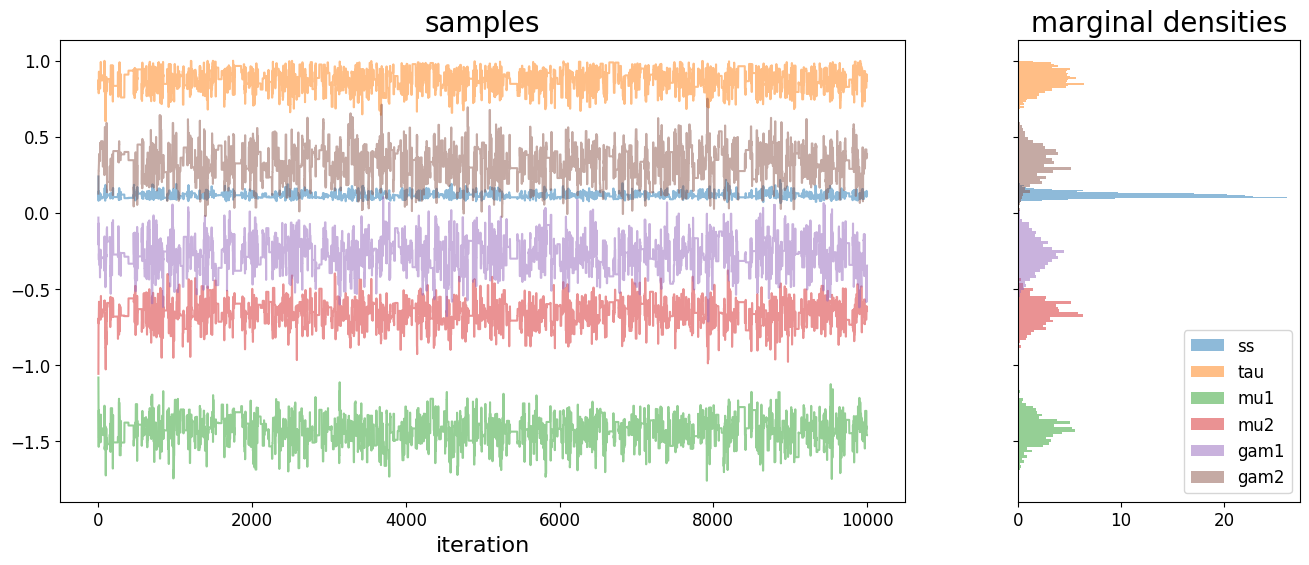

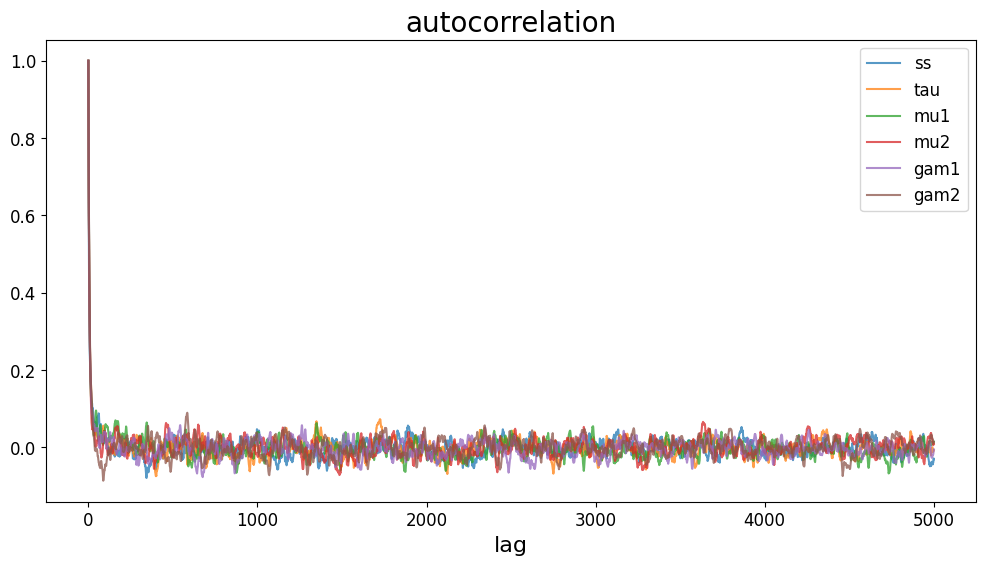

In [52]:
plot_dist(cands_hmc, plot_status=True, status=status_hmc)
plot_marginals(q_hmc)
plot_acorr(q_hmc)

In [53]:
# read-out statistics
stats_hmc = {}
stats_hmc['mean'] = np.mean(q_hmc, axis=0)
stats_hmc['var'] = np.var(q_hmc, axis=0)
stats_hmc['median'] = np.median(q_hmc, axis=0)
for pctl in [0, 10, 25, 50, 75, 90, 100]:s
    stats_hmc[f'p{pctl}'] = np.percentile(q_hmc, pctl, axis=0)
stats_hmc = pd.DataFrame(stats_hmc).T
stats_hmc.columns = THETA_LABELS
print('univariate statistics')
display(stats_hmc)

# covariance
cov_hmc = pd.DataFrame(np.cov(q_hmc.T))
cov_hmc.columns = THETA_LABELS
cov_hmc.index = THETA_LABELS
print('covariance')
display(cov_hmc)

univariate statistics


,ss,tau,mu1,mu2,gam1,gam2
mean,0.116504,0.876061,-1.426506,-0.655593,-0.271189,0.328081
var,0.000348,0.004600,0.008185,0.007247,0.012136,0.011659
median,0.114722,0.879601,-1.423761,-0.656468,-0.269686,0.327901
p0,0.064362,0.601320,-1.760187,-1.057748,-0.713246,-0.026835
p10,0.096061,0.782554,-1.537226,-0.762930,-0.415536,0.191056
p25,0.102551,0.830283,-1.486731,-0.708031,-0.342834,0.258800
p50,0.114722,0.879601,-1.423761,-0.656468,-0.269686,0.327901
p75,0.127469,0.929382,-1.369389,-0.596565,-0.196123,0.404570
p90,0.142349,0.965406,-1.310156,-0.552663,-0.125584,0.457856
p100,0.239091,0.999837,-1.081980,-0.378013,0.103744,0.750497


covariance


,ss,tau,mu1,mu2,gam1,gam2
ss,0.000348,-0.000107,-0.000072,-0.000149,0.000059,-0.000006
tau,-0.000107,0.004601,0.003278,0.002411,-0.000979,0.000122
mu1,-0.000072,0.003278,0.008185,0.001597,-0.003621,0.000201
mu2,-0.000149,0.002411,0.001597,0.007248,-0.000028,-0.003019
gam1,0.000059,-0.000979,-0.003621,-0.000028,0.012137,-0.000362
gam2,-0.000006,0.000122,0.000201,-0.003019,-0.000362,0.011660


# Importance sampling

In [304]:
# t distribution
M = (torch.sum(torch.square(Y[groups==1] - torch.mean(Y[groups == 1], axis=0))) + 
     torch.sum(torch.square(Y[groups==2] - torch.mean(Y[groups == 2], axis=0)))).detach().numpy()
t_nu = 2*(ns[0] + ns[1]) - 4
t_Sigma = M/nu * torch.diag(torch.tensor([1/ns[0], 1/ns[0], 1/ns[1], 1/ns[1]]))
t_mu = torch.cat([torch.mean(Y[groups == 1], axis=0), torch.mean(Y[groups == 2], axis=0)]).detach().numpy()

mu1, mu2, gam1, gam2 = sps.multivariate_t.rvs(loc=t_mu, shape=t_Sigma, df=t_nu)
mu = torch.tensor([mu1, mu2])
gam = torch.tensor([gam1, gam2])

In [305]:
def is_tdist_params(Y, groups):
    #get counts
    __, ns = np.unique(groups, return_counts=True)
    n = ns.sum()
    
    # t distribution parameters for mu and gamma
    M = (torch.sum(torch.square(Y[groups==1] - torch.mean(Y[groups == 1], axis=0))) + 
         torch.sum(torch.square(Y[groups==2] - torch.mean(Y[groups == 2], axis=0)))).detach().numpy()
    t_nu = 2*(ns[0] + ns[1]) - 4
    t_Sigma = M/nu * torch.diag(torch.tensor([1/ns[0], 1/ns[0], 1/ns[1], 1/ns[1]]))
    t_mu = torch.cat([torch.mean(Y[groups == 1], axis=0), torch.mean(Y[groups == 2], axis=0)]).detach().numpy()
    
    return t_mu, t_Sigma, t_nu

In [311]:
def val_is_cand(Y, groups):
    std_d = 0.001
    # sample mu and gamma from t
    t_mu, t_Sigma, t_nu = is_tdist_params(Y, groups)

    mu1, mu2, gam1, gam2 = sps.multivariate_t.rvs(loc=t_mu, shape=t_Sigma, df=t_nu)
    mu = torch.tensor([mu1, mu2])
    gam = torch.tensor([gam1, gam2])
    
    # sample ss from inverse gamma
    sum_square = (torch.sum(torch.square(Y[groups == 1] - mu)) + 
                  torch.sum(torch.square(Y[groups == 2] - gam))).detach().numpy()
    ss = sps.invgamma.rvs(a=ns[0] + ns[1], scale=sum_square/2)
    
    tau = sps.uniform.rvs(0.5, 1)
    
    return ss, tau, mu1, mu2, gam1, gam2
    

In [312]:
def weight_is_cand(theta, Y, groups):
    # unravel theta
    ss, tau, mu1, mu2, gam1, gam2 = theta
    mu = torch.tensor([mu1, mu2])
    gam = torch.tensor([gam1, gam2])
    
    #get counts
    __, ns = np.unique(groups, return_counts=True)
    n = ns.sum()
    
    sum_square = (torch.sum(torch.square(Y[groups == 3] - (mu + gam)/2)) + 
                  torch.sum(torch.square(Y[groups == 4] - tau*mu - (1-tau)*gam)))
    
    u = (1/ss)**(ns[2] + ns[3]) * torch.exp(-1/(2*ss) * sum_square)
    
    return u

In [313]:
theta = []
u = []
for i in range(10000):
    theta_i = val_is_cand(Y, groups)
    theta += [theta_i]
    u += [weight_is_cand(theta=theta_i, Y=Y, groups=groups)]

theta = torch.tensor(theta)
u = torch.tensor(u)
w = u / torch.sum(u)

In [314]:
theta_hat = theta
for i in range(theta.shape[1]):
    theta_hat[:,i] = theta_hat[:,i] * w

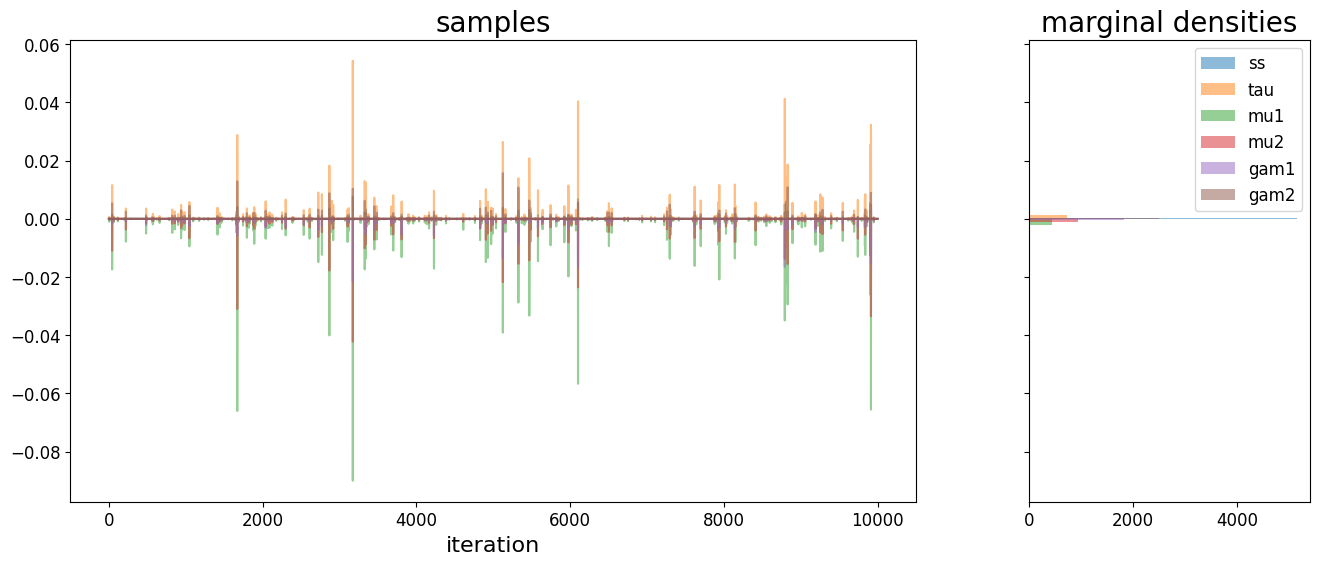

In [316]:
plot_marginals(theta_hat)

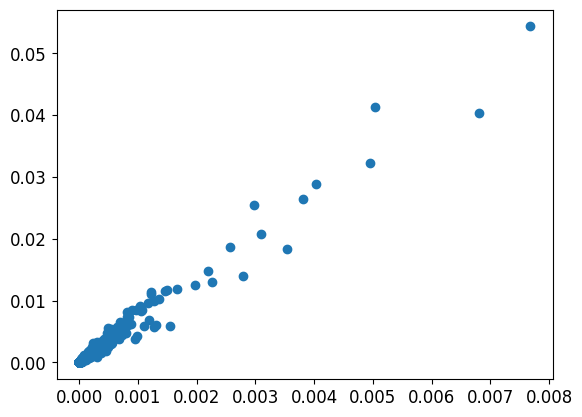

In [315]:
plt.scatter(theta_hat[:,0], theta_hat[:,1])